# 圖片分類

In [243]:
import os
import shutil
# 遍歷資料夾中的檔案
for filename in os.listdir('./hiragana_images'):
    # 判斷檔案是否為 jpg 檔
    if filename.endswith('.jpg'):
        # 取得檔名中的非數字字元
        class_name = os.path.splitext(''.join(filter(lambda x: not x.isdigit(), filename)))[0]
        # 建立目標資料夾
        target_folder = os.path.join('./my_images', class_name)
        if not os.path.exists(target_folder):
            os.mkdir(target_folder)
        # 複製檔案到對應的資料夾中
        shutil.copy(os.path.join('./hiragana_images', filename), os.path.join(target_folder, filename))


# 模型訓練

In [244]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [245]:
# 檢查是否有 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [246]:
# 超參數

num_classes = 50  # 50音分類
batch_size = 10  #訓練樣本數
num_epochs = 25  #一期訓練  Iteration = （Data set size / Batch size）* Epoch = (1000/20)*10 = 5000
learning_rate = 0.001 #學習率

In [247]:
# 數據預處理
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 調整大小為 32x32
    transforms.Grayscale(num_output_channels=1),  # 轉為單通道灰度圖像
    transforms.ToTensor()  # 轉為張量
])

In [248]:
# 載入數據 並將數據分配測試集和訓練集 8:2
train_dataset = datasets.ImageFolder(root='./my_images', transform=transform) # datasets.ImageFolder 會將資料夾中的圖片依照資料夾名稱分類
train_data, test_data = train_test_split(train_dataset, test_size=0.2, random_state=42) #train_test_split 會將資料分成兩部分，一部分用來訓練，一部分用來測試
#訓練集
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)  #每次訓練數量 = Data set size(*0.8) / Batch size = 800/20 = 40
#測試集
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# # 載入數據
# train_dataset = datasets.ImageFolder(root='F:\pycharm_pro\pytorch_learn\my_images', transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


卷積層尺寸變化 =
$$
W_{new} = {W_{o} - Kernelsize + (2 \times Padding) \over Stride} +1
$$

In [249]:
# 定義模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(  # <-- (1,32,32)
            nn.Conv2d(1, 16, kernel_size=3, padding=1), #--> (32,32,32)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #--> (16,16,16)
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),#--> (32,16,16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) #--> (32,8,8)
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),#--> (64,8,8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))#--> (64,4,4)
        self.fc1 = nn.Sequential(
            nn.Linear(4*4*64, 256), #--> (256)
            nn.Dropout(0.2),
            nn.Sigmoid(),
        )
        self.fc2 = nn.Linear(256,num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


In [250]:
# 定義模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(32*32, 512),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
        )
        self.fc4 = nn.Linear(128,num_classes)

    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        return out

In [251]:
# 實例化模型、損失函數和優化器
model = Net().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#可視化模型
from torchsummary import summary
summary(model, input_size=(1, 32, 32), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         524,800
              ReLU-2                  [-1, 512]               0
            Linear-3                  [-1, 256]         131,328
              ReLU-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
            Linear-7                   [-1, 50]           6,450
Total params: 695,474
Trainable params: 695,474
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.65
Estimated Total Size (MB): 2.67
----------------------------------------------------------------


In [252]:
# 訓練模型
total_step = len(train_loader)  #  1 epoch = 800/batch = 40
loss_list =[]
for epoch in range(num_epochs):
    loss = 0
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        # 前向傳播
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 反向傳播和優化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], \
                    Step [{i+1}/{total_step}], \
                    Loss: {loss.item():.4f}')
    loss_list.append(loss.item())



Epoch [1/25],                     Step [10/80],                     Loss: 3.9190
Epoch [1/25],                     Step [20/80],                     Loss: 3.8638
Epoch [1/25],                     Step [30/80],                     Loss: 3.8936
Epoch [1/25],                     Step [40/80],                     Loss: 3.7260
Epoch [1/25],                     Step [50/80],                     Loss: 3.1218
Epoch [1/25],                     Step [60/80],                     Loss: 3.2192
Epoch [1/25],                     Step [70/80],                     Loss: 3.1886
Epoch [1/25],                     Step [80/80],                     Loss: 3.0809
Epoch [2/25],                     Step [10/80],                     Loss: 2.6567
Epoch [2/25],                     Step [20/80],                     Loss: 2.3409
Epoch [2/25],                     Step [30/80],                     Loss: 1.5625
Epoch [2/25],                     Step [40/80],                     Loss: 1.6121
Epoch [2/25],               

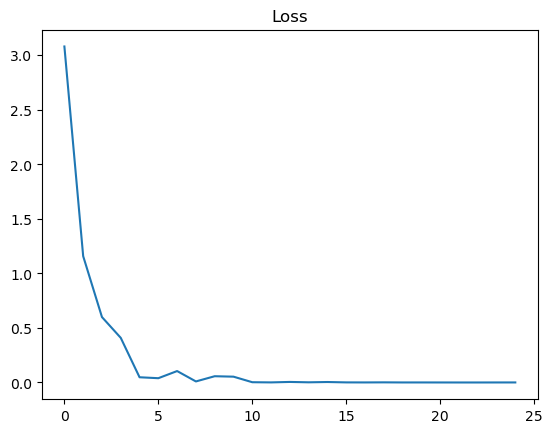

Accuracy of the model on the test images: 90.5 %


In [253]:
# 測試模型
from matplotlib import pyplot as plt
plt.plot(loss_list)
plt.title('Loss')
plt.show()


model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))





# 儲存模型

In [254]:
# 只儲存權重
torch.save(model.state_dict(), '50on_model.ckpt')
# 儲存整個模型和權重
torch.save(model, '50on_model_all.pt')



# 載入模型

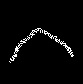

預測結果:kanaHE


In [255]:
import torch
from torchvision import transforms
import torchvision.models as models
from PIL import Image

# 定義圖片轉換
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 調整大小為 32x32
    transforms.Grayscale(num_output_channels=1),  # 轉為單通道灰度圖像
    transforms.ToTensor()  # 轉為張量

])
# 載入圖片
img = Image.open('./test_images/HE.jpg')
display(img)
img = test_transform(img).to(device)
# 增加一維，batch大小設為 1
img = img.unsqueeze(0)


# 載入模型
model = torch.load('50on_model_all.pt')
# 設置模型為評估模式
model.eval().to(device)


# 使用模型進行預測
with torch.no_grad():
    output = model(img)

# 取得預測結果
_, preds = torch.max(output, 1)
label_dict = train_dataset.class_to_idx
reverse_label_dict = {v: k for k, v in label_dict.items()}
print(f'預測結果:{reverse_label_dict[preds.item()]}')